In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw, rdFingerprintGenerator
from rdkit.Chem import rdFMCS
from collections import Counter
from sklearn.cluster import KMeans, DBSCAN
from collections import defaultdict
import numpy as np

In [12]:
smiles_df = pd.read_csv("cluster_x_5559_y_-67-64.csv")
smiles_df = smiles_df.loc[smiles_df["target_seq_label_1"].notna()].reset_index(drop=True)
smiles_df

,Unnamed: 0,UMAP1,UMAP2,SMILES,label,num_atoms,target_seq_label_0,target_seq_label_1
0,609,5.525577,-6.564278,C[C@H]1CC[C@H](Cn2c(N3CCOC[C@H]3c3ccccc3)nc3cc...,NaN,42,['MSHPSPQAKPSNPSNPRVFFDVDIGGERVGRIVLELFADIVPKT...,['MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQ...
1,3405,5.547492,-6.542376,CC(C)(C)NC(=O)Cc1ccc(Cl)c(F)c1-n1c(C2CCCCC2)nc...,NaN,41,['MVLLLCLSCLIFSCLTFSWLKIWGKMTDSKPITKSKSEANLIPS...,['MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQ...
2,3411,5.837636,-6.445503,O=C(O)C1CC(NC(=O)C2NC3(CCCCC3)[C@@]3(C(=O)Nc4c...,NaN,38,['MAAVILESIFLKRSQQKKKTSPLNFKKRLFLLTVHKLSYYEYDF...,['MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQ...
3,4460,5.843000,-6.440102,CN1[C@@H](c2nc(C(=O)O)cs2)[C@H](c2cccc(Cl)c2F)...,NaN,37,['MPKKKPTPIQLNPAPDGSAVNGTSSAETNLEALQKKLEELELDE...,['MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQ...
4,6168,5.508588,-6.592789,CO[C@@H]1CCN(c2nc3cc(-c4noc(=O)[nH]4)nc(-c4cnc...,NaN,39,NaN,['MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQ...
...,...,...,...,...,...,...,...,...
196,266937,5.839120,-6.446105,CN(C)C(=O)[C@@H]1N[C@H](CC(C)(C)C)[C@]2(C(=O)N...,NaN,33,['MPLRHWGMARGSKPVGDGAQPMAAMGGLKVLLHWAGPGGGEPWV...,['MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQ...
197,267479,5.529248,-6.565981,CC[C@H]1[C@H](C)OCCN1c1nc2cc(-c3nc(=O)o[nH]3)n...,NaN,39,['MTTYSDKGAKPERGRFLHFHSVTFWVGNAKQAASFYCSKMGFEP...,['MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQ...
198,267954,5.831964,-6.444614,CC(C)(C)C[C@@H]1N[C@@H](C(=O)N[C@H]2C[C@@](C)(...,NaN,37,['MDGWRRMPRWGLLLLLWGSCTFGLPTDTTTFKRIFLKRMPSIRE...,['MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQ...
199,268535,5.549747,-6.559689,CO[C@H]1COC[C@@H]1N(C)c1nc2cc(-c3noc(=O)[nH]3)...,NaN,39,['MGNAAAAKKGSEQESVKEFLAKAKEDFLKKWESPAQNTAHLDQF...,['MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQ...


In [13]:
compounds = []

for _, smiles in smiles_df["SMILES"].items():
    compounds.append(Chem.MolFromSmiles(smiles))

In [14]:
rdkitGen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
fingerprints = [rdkitGen.GetFingerprint(mol) for mol in compounds]

print(f"Number of compounds converted: {len(fingerprints)}")
print(f"Fingerprint length per compound: {len(fingerprints[0])}")

Number of compounds converted: 201
Fingerprint length per compound: 1024


In [15]:
def tanimotoDistanceMatrix(fpList):
    dissimilarityMatrix = []
    for i in range (1, len(fpList)):
        similarities = DataStructs.BulkTanimotoSimilarity(fpList[i], fpList[:i])
        dissimilarityMatrix.extend([1 - x for x in similarities])
    return dissimilarityMatrix

In [16]:
def clusterFingerprints(fingerprints, cutoff):
    distanceMatrix = tanimotoDistanceMatrix(fingerprints)
    clusters = Butina.ClusterData(distanceMatrix, len(fingerprints), cutoff, isDistData = True)
    clusters = sorted(clusters, key = len, reverse = True)
    return clusters

In [7]:
"""for cutoff in np.arange(0.0, 1.0, 0.1):
    clusters = clusterFingerprints(fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)"""

'for cutoff in np.arange(0.0, 1.0, 0.1):\n    clusters = clusterFingerprints(fingerprints, cutoff=cutoff)\n    fig, ax = plt.subplots(figsize=(15, 4))\n    ax.set_title(f"Threshold: {cutoff:3.1f}")\n    ax.set_xlabel("Cluster index")\n    ax.set_ylabel("Number of molecules")\n    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)'

In [8]:
import psutil
import os

# Sprawdź użycie pamięci
process = psutil.Process(os.getpid())
memory_info = process.memory_info()
print(f"Pamięć używana: {memory_info.rss / 1024 / 1024:.2f} MB")

# Sprawdź rozmiar macierzy odległości
n = len(fingerprints)
matrix_size = (n * (n-1) // 2) * 8 / 1024 / 1024  # 8 bytes per float
print(f"Szacowany rozmiar macierzy odległości: {matrix_size:.2f} MB")
print(f"Liczba porównań: {n * (n-1) // 2}")

Pamięć używana: 6568.63 MB
Szacowany rozmiar macierzy odległości: 290408.37 MB
Liczba porównań: 38064405655


In [17]:
cutoff = 0.35
clusters = clusterWithDiskStorage(fingerprints, cutoff)

In [22]:
lista = clusters[2]
lista = [smiles_df.loc[idx, "SMILES"] for idx in lista if idx in smiles_df.index]

In [23]:
lista

['CC(C)(C)C[C@H]1NC(C(=O)N[C@H]2C[C@@](C)(O)C2)[C@H](c2cccc(Cl)c2F)[C@@]12C(=O)Nc1cc(Cl)ccc12',
 'CC(C)(C)C[C@@H]1N[C@@H](C(=O)Nc2ccc(OCCO)cc2)[C@H](c2cccc(Cl)c2F)[C@]12C(=O)Nc1cc(Cl)ccc12',
 'CC(C)(C)C[C@H]1N[C@@H](C(=O)NC2CCN(S(C)(=O)=O)CC2)[C@H](c2cccc(Cl)c2F)[C@@]12C(=O)Nc1cc(Cl)ccc12',
 'CC(C)(C)C[C@H]1N[C@@H](C(=O)NCC[C@H](O)CO)[C@H](c2cccc(Cl)c2F)[C@@]12C(=O)Nc1cc(Cl)ccc12',
 'COCCOCCNC(=O)[C@@H]1N[C@H](CC(C)(C)C)[C@]2(C(=O)Nc3cc(Cl)ccc32)[C@H]1c1cccc(Cl)c1F',
 'CC(C)(C)C[C@@H]1N[C@@H](C(=O)N[C@H]2C[C@@](C)(O)C2)[C@H](c2cccc(Cl)c2F)[C@]12C(=O)Nc1cc(Cl)c(F)cc12',
 'COc1cc(NC(=O)[C@@H]2N[C@@H](CC(C)(C)C)[C@@]3(C(=O)Nc4cc(Cl)ccc43)[C@H]2c2cccc(Cl)c2F)ccc1C(=O)O',
 'C[C@H](N)C(=O)OC1CCC(NC(=O)[C@@H]2N[C@H](CC(C)(C)C)[C@]3(C(=O)Nc4cc(Cl)ccc43)[C@H]2c2cccc(Cl)c2F)CC1',
 'CCC1(CC)NC(C(=O)N[C@H]2C[C@@](C)(O)C2)C(c2cccc(Cl)c2F)[C@]12C(=O)Nc1cc(Cl)ccc12',
 'CC(C)(C)C[C@H]1N[C@@H](C(=O)NCCN2CCOCC2)[C@@H](c2cccc(Cl)c2F)[C@]12C(=O)Nc1cc(Cl)ccc12',
 'CC(C)(C)C[C@@H]1NC(C(=O)N[C@H]2C[C@@](C)(O

In [25]:
numClustG1 = sum(1 for c in clusters if len(c) == 1)
numClustG5 = sum(1 for c in clusters if len(c) > 5)
numClustG25 = sum(1 for c in clusters if len(c) > 25)
numClustG100 = sum(1 for c in clusters if len(c) > 100)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", numClustG1)
print("# clusters with >5 compounds: ", numClustG5)
print("# clusters with >25 compounds: ", numClustG25)
print("# clusters with >100 compounds: ", numClustG100)

total # clusters:  36
# clusters with only 1 compound:  15
# clusters with >5 compounds:  5
# clusters with >25 compounds:  3
# clusters with >100 compounds:  0


In [24]:
smiles_df["cluster"] = np.nan
for indice in range(len(clusters)):
   for registro in clusters[indice]:
       smiles_df.loc[registro, "cluster"] = indice

smiles_df = smiles_df[smiles_df["SMILES"].notna()]
smiles_df = smiles_df.sort_values(by=["cluster"], ascending=True).reset_index(drop=True)
smiles_df_2 = smiles_df[["SMILES", "cluster"]]
smiles_df_2

,SMILES,cluster
0,COC1CC[C@@H](C)N(c2nc3cc(-c4noc(=O)[nH]4)nc(-c...,0.0
1,CO[C@@H]1CCN(c2nc3cc(-c4noc(=O)[nH]4)nc(-c4cnc...,0.0
2,CC1CN(c2nc3cc(-c4noc(=O)[nH]4)nc(-c4cncc(Cl)c4...,0.0
3,COCCO[C@@H]1C[C@@H](C(C)C)N(c2nc3cc(-c4noc(=O)...,0.0
4,CC(C)C1CCCN1c1nc2cc(-c3noc(=O)[nH]3)nc(-c3cncc...,0.0
...,...,...
196,CC(=O)N1CCC(Oc2ccc(I)cc2[C@@H]2NC(=O)C[C@H](c3...,31.0
197,COc1cc(C(=O)OCOP(=O)(OC(C)(C)C)OC(C)(C)C)ccc1N...,32.0
198,COCCCOc1cc(Cl)ccc1C1(C)c2c(nn(-c3ccccc3OC)c2C(...,33.0
199,[C-]#[N+]c1ccc(C2c3c(nc(-c4cnc(N)nc4OC)n3C(C)C...,34.0


In [27]:
original_coords = smiles_df[["SMILES", "UMAP1", "UMAP2"]]
result_df = pd.merge(smiles_df_2, original_coords, on="SMILES", how="left")
result_df = result_df.drop_duplicates(subset="SMILES", keep="first")
result_df

,SMILES,cluster,UMAP1,UMAP2
0,COC1CC[C@@H](C)N(c2nc3cc(-c4noc(=O)[nH]4)nc(-c...,0.0,5.508903,-6.590385
1,CO[C@@H]1CCN(c2nc3cc(-c4noc(=O)[nH]4)nc(-c4cnc...,0.0,5.508588,-6.592789
2,CC1CN(c2nc3cc(-c4noc(=O)[nH]4)nc(-c4cncc(Cl)c4...,0.0,5.503712,-6.590021
3,COCCO[C@@H]1C[C@@H](C(C)C)N(c2nc3cc(-c4noc(=O)...,0.0,5.521082,-6.578651
4,CC(C)C1CCCN1c1nc2cc(-c3noc(=O)[nH]3)nc(-c3cncc...,0.0,5.512324,-6.585364
...,...,...,...,...
196,CC(=O)N1CCC(Oc2ccc(I)cc2[C@@H]2NC(=O)C[C@H](c3...,31.0,5.843986,-6.436919
197,COc1cc(C(=O)OCOP(=O)(OC(C)(C)C)OC(C)(C)C)ccc1N...,32.0,5.585568,-6.511904
198,COCCCOc1cc(Cl)ccc1C1(C)c2c(nn(-c3ccccc3OC)c2C(...,33.0,5.847342,-6.440091
199,[C-]#[N+]c1ccc(C2c3c(nc(-c4cnc(N)nc4OC)n3C(C)C...,34.0,5.552437,-6.552603


In [ ]:
cutoff = 0.2
clusters = clusterFingerprints(fingerprints, cutoff = cutoff)

In [ ]:
numClustG1 = sum(1 for c in clusters if len(c) == 1)
numClustG5 = sum(1 for c in clusters if len(c) > 5)
numClustG25 = sum(1 for c in clusters if len(c) > 25)
numClustG100 = sum(1 for c in clusters if len(c) > 100)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", numClustG1)
print("# clusters with >5 compounds: ", numClustG5)
print("# clusters with >25 compounds: ", numClustG25)
print("# clusters with >100 compounds: ", numClustG100)

total # clusters:  2026
# clusters with only 1 compound:  1349
# clusters with >5 compounds:  132
# clusters with >25 compounds:  4
# clusters with >100 compounds:  0


In [28]:
smiles_df["cluster"] = np.nan
for indice in range(len(clusters)):
   for registro in clusters[indice]:
       smiles_df.loc[registro, "cluster"] = indice

smiles_df = smiles_df[smiles_df["SMILES"].notna()]
smiles_df = smiles_df.sort_values(by=["cluster"], ascending=True).reset_index(drop=True)
smiles_df_2 = smiles_df[["SMILES", "cluster"]]
smiles_df_2 = smiles_df_2.drop_duplicates(subset="SMILES", keep="first")
smiles_df_2

,SMILES,cluster
0,CC(C)[C@@H]1C[C@@H](O)CN1c1nc2cc(-c3noc(=O)[nH...,0.0
1,CC(C)C1CCCN1c1nc2cc(-c3noc(=O)[nH]3)nc(-c3cncc...,0.0
2,CCO[C@@H]1C[C@@H](CF)N(c2nc3cc(-c4noc(=O)[nH]4...,0.0
3,C[C@H]1C[C@H](O)CN1c1nc2cc(-c3nc(=O)o[nH]3)nc(...,0.0
4,CO[C@H]1CCN(c2nc3cc(-c4nc(=O)o[nH]4)nc(-c4cncc...,0.0
...,...,...
196,Cc1nnc([C@H]2[C@H](c3cccc(Cl)c3F)[C@]3(C(=O)Nc...,31.0
197,O=C(NCCN1CCOCC1)[C@@H]1NC2(CCCCC2)[C@@]2(C(=O)...,32.0
198,CO[C@@H]1C[C@@H](C)N(c2nc3cc(-c4noc(=O)[nH]4)n...,33.0
199,CC[C@@H]1[C@@H](C)OCCN1c1nc2cc(-c3noc(=O)[nH]3...,34.0


In [30]:
original_coords = smiles_df[["SMILES", "UMAP1", "UMAP2"]].drop_duplicates(subset="SMILES", keep="first")
result_df = pd.merge(smiles_df_2, original_coords, on="SMILES", how="left")
result_df

,SMILES,cluster,UMAP1,UMAP2
0,CC(C)[C@@H]1C[C@@H](O)CN1c1nc2cc(-c3noc(=O)[nH...,0.0,5.536557,-6.564476
1,CC(C)C1CCCN1c1nc2cc(-c3noc(=O)[nH]3)nc(-c3cncc...,0.0,5.512324,-6.585364
2,CCO[C@@H]1C[C@@H](CF)N(c2nc3cc(-c4noc(=O)[nH]4...,0.0,5.503681,-6.586120
3,C[C@H]1C[C@H](O)CN1c1nc2cc(-c3nc(=O)o[nH]3)nc(...,0.0,5.507593,-6.591901
4,CO[C@H]1CCN(c2nc3cc(-c4nc(=O)o[nH]4)nc(-c4cncc...,0.0,5.505532,-6.592647
...,...,...,...,...
196,Cc1nnc([C@H]2[C@H](c3cccc(Cl)c3F)[C@]3(C(=O)Nc...,31.0,5.825510,-6.448552
197,O=C(NCCN1CCOCC1)[C@@H]1NC2(CCCCC2)[C@@]2(C(=O)...,32.0,5.840823,-6.433272
198,CO[C@@H]1C[C@@H](C)N(c2nc3cc(-c4noc(=O)[nH]4)n...,33.0,5.515242,-6.580656
199,CC[C@@H]1[C@@H](C)OCCN1c1nc2cc(-c3noc(=O)[nH]3...,34.0,5.524793,-6.555818


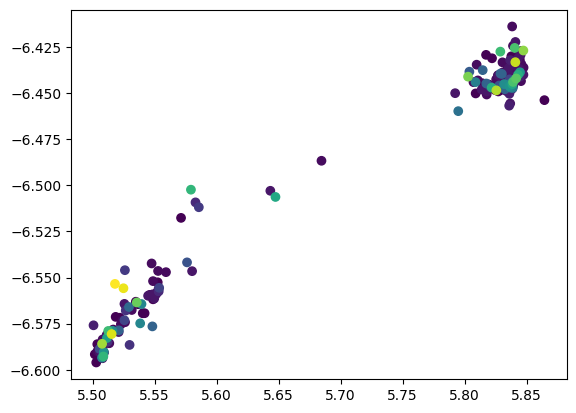

In [32]:
x = result_df["UMAP1"]
y = result_df["UMAP2"]
plt.scatter(x, y, c=result_df["cluster"])
plt.show()

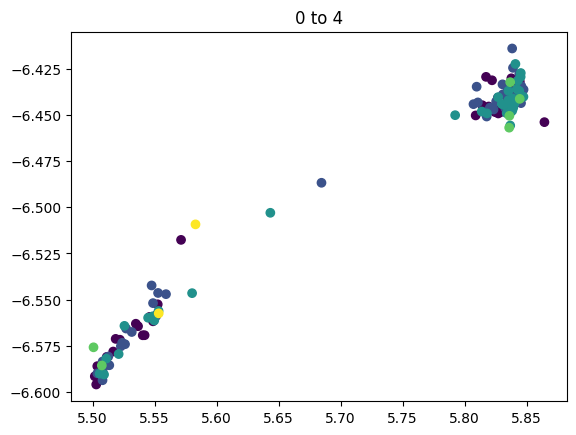

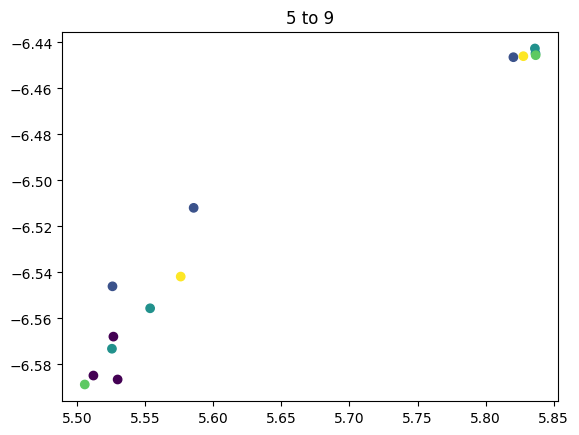

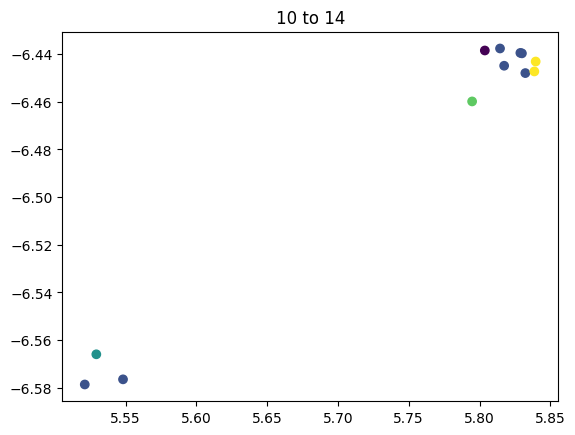

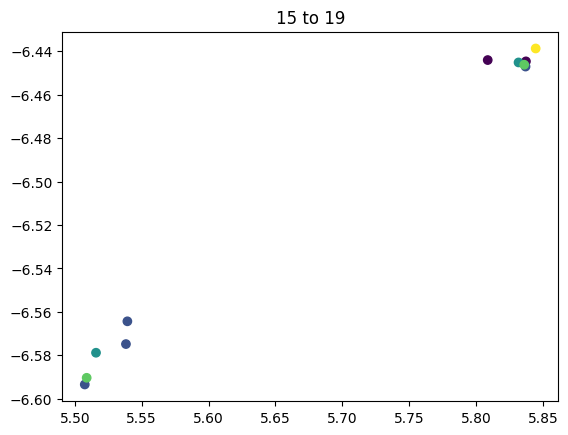

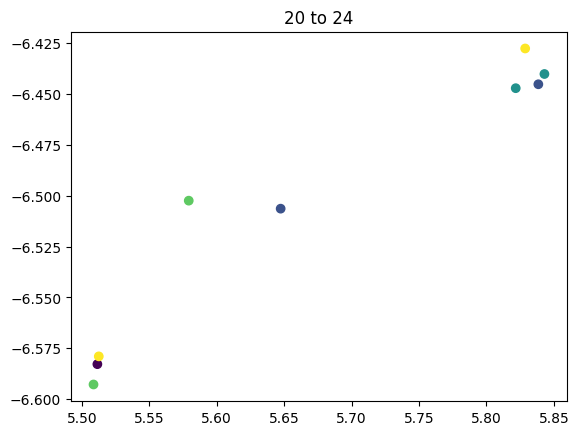

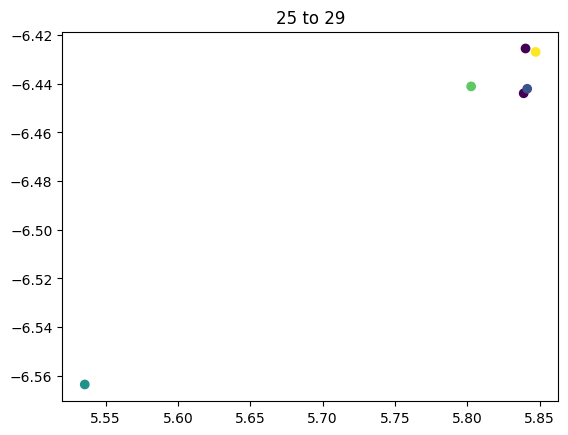

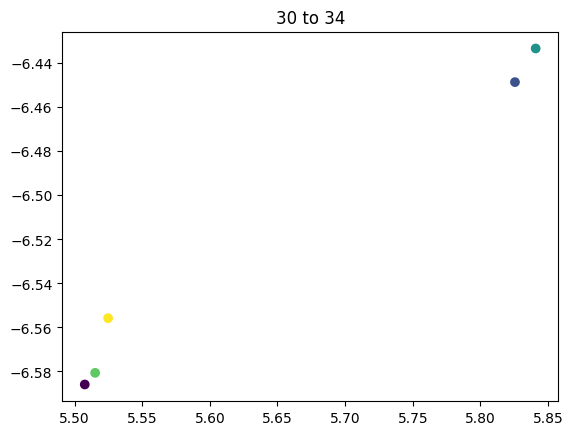

In [35]:
x = result_df["UMAP1"]
y = result_df["UMAP2"]

num_clusters = int(result_df["cluster"].max()) + 1
clusters_per_series = 5

for start in range(0, num_clusters, clusters_per_series):
    end = start + clusters_per_series
    mask = result_df["cluster"].between(start, end - 1)
    plt.figure()
    plt.scatter(result_df.loc[mask, "UMAP1"], result_df.loc[mask, "UMAP2"], c=result_df.loc[mask, "cluster"])
    plt.title(f"{start} to {end - 1}")
    
plt.close()

___________

In [ ]:
import csv

smiles_to_coords = {}
with open("cluster_x_0515_y_-30-39.csv", newline="", encoding="utf-8") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        smiles = row["smiles"]
        x = float(row["x"])
        y = float(row["y"])
        smiles_to_coords[smiles] = (x, y)

coords = []
for smiles in lista:
    if smiles in smiles_to_coords:
        coords.append(smiles_to_coords[smiles])

coords

[]

In [ ]:
listaC = [Chem.MolFromSmiles(c) for c in lista]

In [ ]:
listaFp = []
rdkitGen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
for mol in listaC:
    Chem.SanitizeMol(mol)
    fp = rdkitGen.GetFingerprint(mol)
    listaFp.append(fp)

In [ ]:
from rdkit.SimDivFilters import rdSimDivPickers
lp = rdSimDivPickers.LeaderPicker()

In [ ]:
thresh = 0.7 # <- minimum distance between cluster centroids
picks = lp.LazyBitVectorPick(listaFp,len(listaFp),thresh)
print(len(picks))

1


In [ ]:
pickfps = [listaFp[x] for x in picks]
nearest = []
simhist = []
for i,fpi in enumerate(pickfps):
    tfps = pickfps[:]
    del tfps[i]
    sims = DataStructs.BulkTanimotoSimilarity(fpi,tfps)
    nearest.append(max(sims))
    simhist.extend(sims)
sorted(nearest,reverse=True)

ValueError: max() iterable argument is empty

Text(0.5, 0, 'similarity')

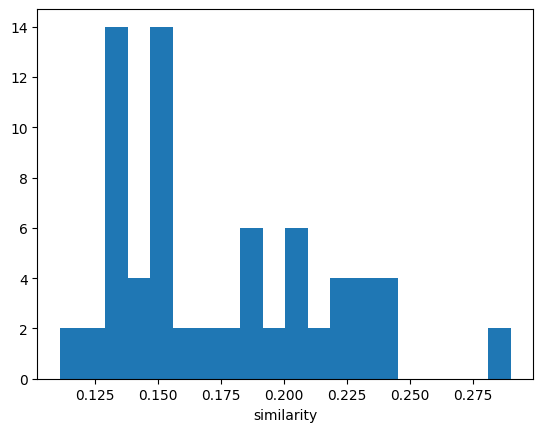

In [ ]:
plt.hist(simhist,bins=20)
plt.xlabel('similarity')

In [ ]:
def assignPointsToClusters(picks,fps):
    clusters = defaultdict(list)
    for i,idx in enumerate(picks):
        clusters[i].append(idx)
    sims = np.zeros((len(picks),len(fps)))
    for i in range(len(picks)):
        pick = picks[i]
        sims[i,:] = DataStructs.BulkTanimotoSimilarity(fps[pick],fps)
        sims[i,i] = 0
    best = np.argmax(sims,axis=0)
    for i,idx in enumerate(best):
        if i not in picks:
            clusters[idx].append(i)
    return clusters

In [ ]:
clusters = assignPointsToClusters(picks, listaFp)

In [ ]:
cluster_labels = [None] * len(lista)
for cluster_id, indices in clusters.items():
    for idx in indices:
        cluster_labels[idx] = cluster_id
cluster_labels

[0,
 1,
 1,
 1,
 3,
 3,
 3,
 3,
 2,
 3,
 0,
 0,
 4,
 4,
 4,
 5,
 3,
 3,
 6,
 6,
 6,
 1,
 1,
 3,
 3,
 3,
 3,
 2,
 7,
 1,
 1,
 1,
 5,
 4,
 1,
 4,
 8,
 0,
 3,
 8]

In [ ]:
data = []
for cluster_id, indices in clusters.items():
    for idx in indices:
        if idx < len(lista) and idx < len(coords):
            smiles = lista[idx]
            x, y = coords[idx]
            data.append({'smiles': smiles, 'x': x, 'y': y, 'cluster': cluster_labels[idx]})

df_clusters = pd.DataFrame(data)
df_clusters

,smiles,x,y,cluster
0,COc1ncc(-n2nc3c(c2C(C)C)[C@@H](c2ccc(Cl)cc2C)N...,0.994933,-3.668455,0
1,COc1ccccc1-n1nc2c(c1C(C)C)C(c1ccc(Cl)cc1C)N(c1...,0.994168,-3.674778,0
2,Cc1cc(Cl)ccc1C1c2c(nn(CCc3ccccn3)c2C(C)C)C(=O)...,0.990527,-3.676072,0
3,C[C@]1(CC(=O)O)C[C@H](c2cccc(Cl)c2)[C@@H](c2cc...,0.949164,-3.636607,1
4,CCS(=O)(=O)C[C@H](C1CC1)N1C(=O)[C@@](C)(CC(=O)...,0.951003,-3.656335,1
5,CC[C@@H](CN1CC(C)(C)OC1=O)N1C(=O)[C@@](C)(CC(=...,0.935908,-3.684750,1
6,CN(C[C@H](C1CC1)N1C(=O)[C@@](C)(CC(=O)O)C[C@H]...,0.942618,-3.653265,1
7,C[C@]1(CC(=O)O)C[C@H](c2cccc(Cl)c2)[C@@H](c2cc...,0.926006,-3.677452,1
8,CC[C@@H](CCC#N)N1C(=O)[C@@H](CC(=O)O)C[C@H](c2...,0.932577,-3.656073,1
9,CC[C@@H](C(=O)OC(C)(C)C)N1C(=O)[C@@H](CC(=O)O)...,0.990860,-3.628047,1


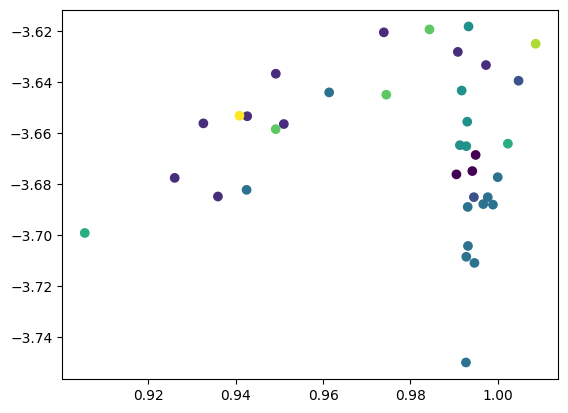

In [ ]:
x = df_clusters["x"]
y = df_clusters["y"]

plt.scatter(x, y, c=df_clusters["cluster"])